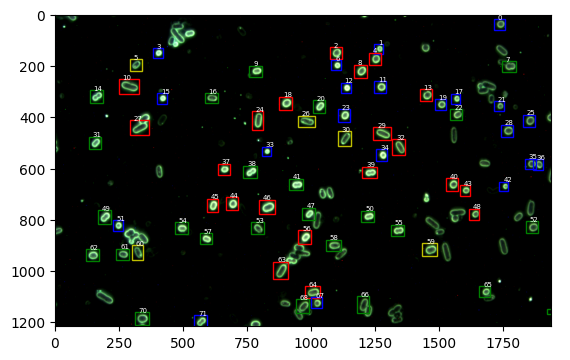

In [90]:
import json
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# 读取JSON文件
with open('blind test single_cell/json_files/ABCD.json', 'r') as file:
    data = json.load(file)
# 提取 'regions' 数据
regions_data = [item['regions'] for item in data.values() if 'regions' in item]
results_data = [item['results'] for item in data.values() if 'results' in item]
#print(data)
#print(regions_data)
#print(results_data)
#print(regions_coordinates[0])
# 加载图像
# 替换'image_path.jpg'为你的图像路径
image_path = 'blind test single_cell/raw_imgs/ABCD.tif'
image = Image.open(image_path)
image = np.array(image)

# 创建绘图
fig, ax = plt.subplots()
ax.imshow(image)
# 颜色映射，根据分类结果选择颜色
colors = {0: 'r', 1: 'g', 2: 'b', 3: 'y'}

# 根据JSON文件中的坐标在图像上绘制矩形框
for i in range(len(results_data)):
    # 创建一个矩形框
    coord = regions_data[i]
    result = results_data[i]
    color = colors.get(result, 'w')
    x1,y1 =coord['min_col']-10, coord['min_row']-10
    w= coord['max_col'] - coord['min_col']+15
    h= coord['max_row']- coord['min_row']+15
    rect = patches.Rectangle((x1,y1), w,h, linewidth=1, edgecolor=color, facecolor='none')
    # 将矩形框添加到绘图中
    ax.add_patch(rect)
    ax.text(coord['min_col']+5, coord['min_row']-10, str(i),
            color='white', fontsize =5, bbox=dict(facecolor='black',alpha =0))
output_file_path = 'ABCD.png'
plt.savefig(output_file_path, dpi=600)
# 显示图像
plt.show()



In [ ]:
###load model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = GhostNet(num_classes=4)
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)
model.eval()  # 将模型设置为评估模式

####load data
loaded_data = load_json_paths('3D_bacteria_cells.json')
test_paths, test_labels = loaded_data["train_paths"], loaded_data["train_labels"]
test_dataset = HyperspectralDataset(test_paths, test_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [9]:
####sort hpy files to npy files
from dataset_prepare import convert_hyp_to_npy,envi_open,collect_file_paths
folder_path='blind test single_cell/single cells_envi'
target_path='blind test single_cell/single cells_npy'
convert_hyp_to_npy(folder_path,target_path)

Processing folders: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
Processing folders: 0it [00:00, ?it/s]
Processing folders: 0it [00:00, ?it/s]
Processing folders: 0it [00:00, ?it/s]
Processing folders: 0it [00:00, ?it/s]
Processing folders: 0it [00:00, ?it/s]
Processing folders: 0it [00:00, ?it/s]
Processing folders: 0it [00:00, ?it/s]


In [55]:
###load npy data from blind test files
from data.dataloader import collect_file_paths,HyperspectralDataset_nolabel
from torch.utils.data import DataLoader
import os
cell_dir='blind test single_cell/single cells_npy/BCD'
cell_paths=[os.path.join(cell_dir,file) for file in sorted(os.listdir(cell_dir)) if file.endswith('.npy')]
print(cell_paths)
test_dataset = HyperspectralDataset_nolabel(cell_paths)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
print(test_dataset)
#dataset = HyperspectralDataset(file_paths, labels)

['blind test single_cell/single cells_npy/BCD/BCD_000_origin.npy', 'blind test single_cell/single cells_npy/BCD/BCD_001_origin.npy', 'blind test single_cell/single cells_npy/BCD/BCD_002_origin.npy', 'blind test single_cell/single cells_npy/BCD/BCD_003_origin.npy', 'blind test single_cell/single cells_npy/BCD/BCD_004_origin.npy', 'blind test single_cell/single cells_npy/BCD/BCD_005_origin.npy', 'blind test single_cell/single cells_npy/BCD/BCD_006_origin.npy', 'blind test single_cell/single cells_npy/BCD/BCD_007_origin.npy', 'blind test single_cell/single cells_npy/BCD/BCD_008_origin.npy', 'blind test single_cell/single cells_npy/BCD/BCD_009_origin.npy', 'blind test single_cell/single cells_npy/BCD/BCD_010_origin.npy', 'blind test single_cell/single cells_npy/BCD/BCD_011_origin.npy', 'blind test single_cell/single cells_npy/BCD/BCD_012_origin.npy', 'blind test single_cell/single cells_npy/BCD/BCD_013_origin.npy', 'blind test single_cell/single cells_npy/BCD/BCD_014_origin.npy', 'blind te

In [56]:
# load model
import torch
from nn.net import GhostNet
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = GhostNet(num_classes=4)
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))
model = model.to(device)
model.eval()  # 将模型设置为评估模式
###inference results
results=[]
with torch.no_grad():  # 在评估过程中不计算梯度
    for inputs in test_loader:
        inputs= inputs.to(device)
        inputs = inputs.unsqueeze(2)  ###[32,256,1,64,64]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        results.append(predicted)

In [57]:
print(results)

[tensor([3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])]


In [58]:
# results 存储到相应的json文件中
import json
predictions=results[0]
print(predictions)
json_file='blind test single_cell/json_files/BCD.json'
with open(json_file, 'r') as file:
    data = json.load(file)
regions=data
print(len(regions))
#print(data)
# # 添加预测结果
all_predictions = {}
for idx, prediction in enumerate(predictions, start=0):  # start=1 使序列号从1开始
    all_predictions[idx] = {
        'regions': regions[idx],
        'results': prediction.item()
    }


# 将更新后的数据写回 JSON 文件
with open(json_file, 'w') as file:
    json.dump(all_predictions, file, indent=4)

tensor([3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
61


In [59]:
predictions[0]

tensor(3)